In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime

import json
import os
from dotenv import load_dotenv #pip install python-dotenv

from bs4 import BeautifulSoup
import requests 

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import warnings
warnings.filterwarnings("ignore")

from my_functions import check_duplicates_masters

In [4]:
# comprovar quantes requests he fet i quantes me'n queden

url_search = "https://api.discogs.com/database/search"

params = {
    "type": "release"  # Search for masters
    , "format": "album"           # just search for albums
    , "per_page": 100    # Number of results per page (max 100)
    , "page": 1          # Start with page 1
    , 'country': 'UK'
    , "year": 2015
    , 'genre': 'Rock'
    # , "style": style
}

headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url_search, headers=headers, params=params)

rate_limit = response.headers.get("X-Discogs-Ratelimit")
rate_limit_used = response.headers.get("X-Discogs-Ratelimit-Used")
rate_limit_remaining = response.headers.get("X-Discogs-Ratelimit-Remaining")

print(f"Rate Limit: {rate_limit}")
print(f"Rate Limit Used: {rate_limit_used}")
print(f"Rate Limit Remaining: {rate_limit_remaining}")

Rate Limit: 60
Rate Limit Used: 50
Rate Limit Remaining: 10


### **Proves**: un any en un país

In [18]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

genres = ["Blues", "Classical", "Electronic", "Folk, World, & Country", "Funk / Soul", "Hip-Hop", "Jazz", "Latin", "Pop", "Rock", "Stage & Screen"]
rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
              , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

for style in rock_styles:
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'UK'
        , 'year': 1984
        , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{style}: {items_number}")

Pop Rock: 665
Punk: 269
Alternative Rock: 170
Indie Rock: 162
Hardcore: 28
Rock & Roll: 116
Hard Rock: 219
Psychedelic Rock: 112
Black Metal: 6
Heavy Metal: 235
Folk Rock: 143
Experimental: 95
Prog Rock: 187
Death Metal: 0
Garage Rock: 29


In [19]:
# get one style in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100    # Number of results per page (max 100)
    , 'type': 'release'
    , 'format': 'album'
    , 'page': 1

    # items to change
    , 'country': 'UK'
    , 'year': 1984
    , 'genre': 'Rock'
    # , 'style': 'Alternative Rock'
}

response = requests.get(url, headers=headers, params=params)
data = response.json()
items_number = response.json()['pagination']['items']  # number of items

print(f"Items: {items_number}")

# response.json()

Items: 2545


### **``master_id = 0``**

In [ ]:
url_search = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')

# rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
#               , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

# create empty lists
artist_id_list = []
artists_list = []
titles_list = []
years_list = []
release_countries_list = []
album_length_list = []
tracks_list = []
release_type_list = []
genres_list = []
styles_list = []
master_id_new_list = []
artist_profile_list = []
main_release_id_list = []

attempts = 0
scrapped = 0
start_year = 1982

for year in range(start_year, start_year-1, -1):
    print(f'Year: {year}')

    # for style in rock_styles:
    #     print(f'Style: {style}')

    # Define parameters for album search
    params = {
        "type": "release"  # Search for masters
        , "format": "album"           # just search for albums
        , "per_page": 100    # Number of results per page (max 100)
        , "page": 1          # Start with page 1
        , 'country': 'UK'
        , "year": year
        , 'genre': 'Rock'
    }

    response1 = requests.get(url_search, headers=headers, params=params)
    time.sleep(1)
    data1 = response1.json()

    items = data1['pagination']['items']
    print(f'Items: {items} releases')

    pages = data1['pagination']['pages']+1
    
    for page in range(1, pages):
        print(f'------------ Page: {page} of {pages-1}, {year} -------------')

        params['page'] = page     # change pages
        response2 = requests.get(url_search, headers=headers, params=params)
        data2 = response2.json()

        for id in range(len(data2['results'])):
            try:
                attempts+=1
                time.sleep(1)

                master_id = data2['results'][id]['master_id']
                release_id = data2['results'][id]['id']

                if master_id == 0:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}')
                    try:
                        url_release = f"https://api.discogs.com/releases/{release_id}"
                        response3 = requests.get(url_release, headers=headers)
                        time.sleep(1)
                        data3 = response3.json()
                        artist = data3['artists'][0]['name']

                        if artist == 'Various':
                                print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: Compilation') 
                                continue   # I don't want compilations
                        else:
                        # define the data I want to get
                            title = data3['title']
                            release_year = data3['year']                
                            genres = data3['genres']
                            styles = data3['styles']

                        # a more complex information is the total duration of the album, I have to sum the durations of each song
                            number_of_songs = len(data3['tracklist'])
                            song_durations = []

                            for song in range(number_of_songs):
                                song_duration = data3['tracklist'][song]['duration']
                                try:
                                    minutes = int(song_duration.split(':')[0])
                                    seconds = int(song_duration.split(':')[1])
                                    song_duration_minutes = minutes + seconds/60
                                    song_durations.append(song_duration_minutes)
                                except:
                                    pass
                                album_length = round(sum(i for i in song_durations), 2)

                            artist_id = data3['artists'][0]['id']

                        # define the data I want to get
                            release_country = data3['country']
                            release_type = data3['formats'][0]['descriptions']

                        # artist page
                            url = f"https://api.discogs.com/artists/{artist_id}"
                            time.sleep(1)
                            response5 = requests.get(url, headers=headers)
                            data5 = response5.json()

                        # define the data I want to get
                            try:
                                artist_profile = data5['profile']
                            except:
                                artist_profile = np.nan
                                pass

                        # save the info in the lists
                            artist_id_list.append(str(artist_id))
                            artists_list.append(artist)
                            titles_list.append(title)
                            years_list.append(release_year)
                            genres_list.append(genres)
                            styles_list.append(styles)
                            master_id_new_list.append(np.nan)
                            album_length_list.append(album_length)
                            tracks_list.append(number_of_songs)
                            release_countries_list.append(release_country)
                            release_type_list.append(release_type)
                            main_release_id_list.append(release_id)

                            if artist_profile == '':
                                artist_profile_list.append(np.nan)
                            else:
                                artist_profile_list.append(artist_profile)

                            scrapped+=1

                        # list lengths
                            lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                    , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                        # Check if all lists have the same length
                            lengths = [len(lst) for lst in lists]
                            if len(set(lengths)) != 1:
                                print("Lengths are not the same.")
                                break # stop the loop, I won't be able to store the data if I have one value missing

                            print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: {artist} - {title}')
                            time.sleep(1)
                    except:
                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: {artist} - {title} - Album not found')
                        continue    # sometimes it crashes for some unknown reason, so I skip this album and continue
                
                elif master_id in master_id_new_list:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already in list') 
                    continue        # there are several releases of the same master_release, I just want one (the master_release)
                elif master_id in df_masters_scrapped['master_id'].values:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already scrapped') 
                    continue        # I have already scrapped it before
                else:
                    url_master = f"https://api.discogs.com/masters/{master_id}"
                    response3 = requests.get(url_master, headers=headers)
                    time.sleep(1)
                    data3 = response3.json()

                    artist = data3['artists'][0]['name']

                    if artist == 'Various':
                            print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: Compilation') 
                            continue   # I don't want compilations
                    else:
                    # define the data I want to get
                        title = data3['title']
                        release_year = data3['year']                 
                        genres = data3['genres']
                        styles = data3['styles']

                    # a more complex information is the total duration of the album, I have to sum the durations of each song
                        number_of_songs = len(data3['tracklist'])
                        song_durations = []

                        for song in range(number_of_songs):
                            song_duration = data3['tracklist'][song]['duration']
                            try:
                                minutes = int(song_duration.split(':')[0])
                                seconds = int(song_duration.split(':')[1])
                                song_duration_minutes = minutes + seconds/60
                                song_durations.append(song_duration_minutes)
                            except:
                                pass
                            album_length = round(sum(i for i in song_durations), 2)

                        main_release_id = data3['main_release']
                        artist_id = data3['artists'][0]['id']

                    # release page
                        url = f"https://api.discogs.com/releases/{main_release_id}"
                        time.sleep(1)
                        response4 = requests.get(url, headers=headers)
                        data4 = response4.json()

                    # define the data I want to get
                        release_country = data4['country']
                        release_type = data4['formats'][0]['descriptions']

                    # artist page
                        url = f"https://api.discogs.com/artists/{artist_id}"
                        time.sleep(1)
                        response5 = requests.get(url, headers=headers)
                        data5 = response5.json()

                    # define the data I want to get
                        try:
                            artist_profile = data5['profile']
                        except:
                            artist_profile = np.nan
                            pass

                    # save the info in the lists
                        artist_id_list.append(str(artist_id))
                        artists_list.append(artist)
                        titles_list.append(title)
                        years_list.append(release_year)
                        genres_list.append(genres)
                        styles_list.append(styles)
                        master_id_new_list.append(master_id)
                        album_length_list.append(album_length)
                        tracks_list.append(number_of_songs)
                        release_countries_list.append(release_country)
                        release_type_list.append(release_type)
                        main_release_id_list.append(main_release_id)

                        if artist_profile == '':
                            artist_profile_list.append(np.nan)
                        else:
                            artist_profile_list.append(artist_profile)

                        scrapped+=1

                    # list lengths
                        lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                    # Check if all lists have the same length
                        lengths = [len(lst) for lst in lists]
                        if len(set(lengths)) != 1:
                            print("Lengths are not the same.")
                            break # stop the loop, I won't be able to store the data if I have one value missing

                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: {artist} - {title}')
                        time.sleep(1)
            except:
                print('Strange error')
                continue    # sometimes it crashes for some unknown reason, so I skip this album and continue

Year: 1983
Items: 2272 releases
------------ Page: 1 of 23, 1983 -------------
1 attempts - 0 scrapped - 1/2272 - master_id 33650 already scrapped
2 attempts - 0 scrapped - 2/2272 - master_id 35357 already scrapped
3 attempts - 0 scrapped - 3/2272 - master_id 48240 already scrapped
4 attempts - 1 scrapped - 4/2272 - master_id 114659: Chris Rea - Water Sign
5 attempts - 1 scrapped - 5/2272 - master_id 16101 already scrapped
6 attempts - 1 scrapped - 6/2272 - master_id 254300 already scrapped
7 attempts - 2 scrapped - 7/2272 - master_id 677394: Katrina And The Waves - Shock Horror!
8 attempts - 2 scrapped - 8/2272 - master_id 95233 already scrapped
9 attempts - 3 scrapped - 9/2272 - master_id 88994: Pat Benatar - Live From Earth
10 attempts - 4 scrapped - 10/2272 - master_id 422647: Buddy Holly - For The First Time Anywhere
11 attempts - 4 scrapped - 11/2272 - master_id 28911 already scrapped
12 attempts - 4 scrapped - 12/2272 - master_id 33671 already scrapped
13 attempts - 5 scrapped -

### **Rock masters from a specific country**

In [2]:
df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')
df_masters_scrapped.shape

(43833, 13)

In [25]:
url_search = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')

# rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
#               , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

# create empty lists
artist_id_list = []
artists_list = []
titles_list = []
years_list = []
release_countries_list = []
album_length_list = []
tracks_list = []
release_type_list = []
genres_list = []
styles_list = []
master_id_new_list = []
artist_profile_list = []
main_release_id_list = []

attempts = 0
scrapped = 0
start_year = 1983

for year in range(start_year, start_year-1, -1):
    print(f'Year: {year}')

    # for style in rock_styles:
    #     print(f'Style: {style}')

    # Define parameters for album search
    params = {
        "type": "release"  # Search for masters
        , "format": "album"           # just search for albums
        , "per_page": 100    # Number of results per page (max 100)
        , "page": 1          # Start with page 1
        , 'country': 'UK'
        , "year": year
        , 'genre': 'Rock'
    }

    response1 = requests.get(url_search, headers=headers, params=params)
    time.sleep(1)
    data1 = response1.json()

    items = data1['pagination']['items']
    print(f'Items: {items} releases')

    pages = data1['pagination']['pages']+1
    
    for page in range(1, pages):
        print(f'------------ Page: {page} of {pages-1}, {year} -------------')

        params['page'] = page     # change pages
        response2 = requests.get(url_search, headers=headers, params=params)
        data2 = response2.json()

        for id in range(len(data2['results'])):
            try:
                attempts+=1
                time.sleep(1)

                master_id = data2['results'][id]['master_id']

                if master_id == 0:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}')
                    continue        # I cannot get info 
                elif master_id in master_id_new_list:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already in list') 
                    continue        # there are several releases of the same master_release, I just want one (the master_release)
                elif master_id in df_masters_scrapped['master_id'].values:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already scrapped') 
                    continue        # I have already scrapped it before
                else:
                    url_master = f"https://api.discogs.com/masters/{master_id}"
                    response3 = requests.get(url_master, headers=headers)
                    time.sleep(1)
                    data3 = response3.json()

                    artist = data3['artists'][0]['name']

                    if artist == 'Various':
                            print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: Compilation') 
                            continue   # I don't want compilations
                    else:
                    # define the data I want to get
                        title = data3['title']
                        release_year = data3['year']                 
                        genres = data3['genres']
                        styles = data3['styles']

                    # a more complex information is the total duration of the album, I have to sum the durations of each song
                        number_of_songs = len(data3['tracklist'])
                        song_durations = []

                        for song in range(number_of_songs):
                            song_duration = data3['tracklist'][song]['duration']
                            try:
                                minutes = int(song_duration.split(':')[0])
                                seconds = int(song_duration.split(':')[1])
                                song_duration_minutes = minutes + seconds/60
                                song_durations.append(song_duration_minutes)
                            except:
                                pass
                            album_length = round(sum(i for i in song_durations), 2)

                        main_release_id = data3['main_release']
                        artist_id = data3['artists'][0]['id']

                    # release page
                        url = f"https://api.discogs.com/releases/{main_release_id}"
                        time.sleep(1)
                        response4 = requests.get(url, headers=headers)
                        data4 = response4.json()

                    # define the data I want to get
                        release_country = data4['country']
                        release_type = data4['formats'][0]['descriptions']

                    # artist page
                        url = f"https://api.discogs.com/artists/{artist_id}"
                        time.sleep(1)
                        response5 = requests.get(url, headers=headers)
                        data5 = response5.json()

                    # define the data I want to get
                        try:
                            artist_profile = data5['profile']
                        except:
                            artist_profile = np.nan
                            pass

                    # save the info in the lists
                        artist_id_list.append(str(artist_id))
                        artists_list.append(artist)
                        titles_list.append(title)
                        years_list.append(release_year)
                        genres_list.append(genres)
                        styles_list.append(styles)
                        master_id_new_list.append(master_id)
                        album_length_list.append(album_length)
                        tracks_list.append(number_of_songs)
                        release_countries_list.append(release_country)
                        release_type_list.append(release_type)
                        main_release_id_list.append(main_release_id)

                        if artist_profile == '':
                            artist_profile_list.append(np.nan)
                        else:
                            artist_profile_list.append(artist_profile)

                        scrapped+=1

                    # list lengths
                        lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                    # Check if all lists have the same length
                        lengths = [len(lst) for lst in lists]
                        if len(set(lengths)) != 1:
                            print("Lengths are not the same.")
                            break # stop the loop, I won't be able to store the data if I have one value missing

                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: {artist} - {title}')
                        time.sleep(1)
            except:
                print('Strange error')
                continue    # sometimes it crashes for some unknown reason, so I skip this album and continue

Year: 1983
Items: 2272 releases
------------ Page: 1 of 23, 1983 -------------
1 attempts - 0 scrapped - 1/2272 - master_id 33650 already scrapped
2 attempts - 0 scrapped - 2/2272 - master_id 35357 already scrapped
3 attempts - 0 scrapped - 3/2272 - master_id 48240 already scrapped
4 attempts - 1 scrapped - 4/2272 - master_id 114659: Chris Rea - Water Sign
5 attempts - 1 scrapped - 5/2272 - master_id 16101 already scrapped
6 attempts - 1 scrapped - 6/2272 - master_id 254300 already scrapped
7 attempts - 2 scrapped - 7/2272 - master_id 677394: Katrina And The Waves - Shock Horror!
8 attempts - 2 scrapped - 8/2272 - master_id 95233 already scrapped
9 attempts - 3 scrapped - 9/2272 - master_id 88994: Pat Benatar - Live From Earth
10 attempts - 4 scrapped - 10/2272 - master_id 422647: Buddy Holly - For The First Time Anywhere
11 attempts - 4 scrapped - 11/2272 - master_id 28911 already scrapped
12 attempts - 4 scrapped - 12/2272 - master_id 33671 already scrapped
13 attempts - 5 scrapped -

In [ ]:
# UK 1991

# Pop Rock: 708
# Punk: 354
# Alternative Rock: 414
# Indie Rock: 490
# Hardcore: 103
# Rock & Roll: 111
# Hard Rock: 318
# Psychedelic Rock: 180
# Black Metal: 6
# Heavy Metal: 187
# Folk Rock: 311
# Experimental: 122
# Prog Rock: 191
# Death Metal: 63
# Garage Rock: 69

453+904+731+976+254+154+312+633+146+197+326+465+399+133+141

2922

In [26]:
(79*60)/2272

2.086267605633803

### **Saving the data**

In [27]:
data = pd.DataFrame({'artist_id': artist_id_list
                        , 'master_id': master_id_new_list
                        , 'main_release_id': main_release_id_list
                        , 'release_country': release_countries_list
                        , 'artist': artists_list
                        , 'title': titles_list
                        , 'year': years_list
                        , 'album_length': album_length_list
                        , 'tracks': tracks_list
                        , 'release_type': release_type_list
                        , 'genres': genres_list
                        , 'styles': styles_list
                        , 'artist_profile': artist_profile_list
                        })
data.shape

(463, 13)

In [28]:
print(f'{data.shape[0]} releases\n{data.artist.nunique()} different artists')

463 releases
415 different artists


In [29]:
data.sample(10)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
405,151369,318401,2702354,Germany,Jim Capaldi,Fierce Heart,1983,36.10,9,"[LP, Album, Stereo]",[Rock],"[Blues Rock, Rock & Roll, Classic Rock]","Jim Capaldi (born 2 August 1944, Evesham, Worc..."
283,3865370,438107,3942714,US,Sweet Comfort Band,Cutting Edge,1982,38.22,10,"[LP, Album]",[Rock],"[Soft Rock, Gospel, Arena Rock]",NaN
417,1677801,1754511,12213832,UK,Andrew Lloyd Webber And Tim Rice,Joseph And The Amazing Technicolor Dreamcoat (...,1973,0.00,2,"[LP, Album, Stereo]","[Rock, Stage & Screen]",[Musical],NaN
245,243020,217320,2099166,UK,Savoy Brown,Street Corner Talking,1971,0.00,7,"[LP, Album, Stereo]",[Rock],[Blues Rock],"Savoy Brown, originally known as the Savoy Bro..."
252,234181,357738,2251346,Canada,Robin Trower,Back It Up,1983,38.08,9,"[LP, Album, Stereo]","[Rock, Blues]",[Blues Rock],British guitar player born on 9 March 1945 in ...
389,362004,303578,1979109,UK & Europe,Paul Kantner,Planet Earth Rock And Roll Orchestra,1983,40.48,14,"[LP, Album]",[Rock],[Psychedelic Rock],"Paul Lorin Kantner (March 17, 1941, San Franci..."
399,5269156,619383,3705446,Germany,Lyle McGuinness Band,Acting On Impulse,1983,37.98,12,"[LP, Album]","[Rock, Pop, Folk, World, & Country]",[],"After the demise of [a366226], [a831046] brief..."
271,236897,41035,1616259,Netherlands,Mark Knopfler,Local Hero,1983,44.17,14,"[LP, Album]","[Jazz, Rock, Stage & Screen]","[Folk Rock, Soundtrack, Smooth Jazz, Fusion, R...","British guitarist, singer and songwriter, born..."
169,1066517,347783,2959527,US,DNA (22),Party Tested,1983,30.88,7,"[LP, Album]",[Rock],"[Prog Rock, Heavy Metal]",80's Rock band.
296,1357243,266101,4884119,US,The Paisleys,Cosmic Mind At Play,1970,37.03,7,"[LP, Album, Stereo]",[Rock],[Psychedelic Rock],The Paisleys were a psychedelic pop / rock ban...


In [30]:
data.release_country.value_counts().head()

release_country
UK         234
US         130
Europe      18
Germany     16
Canada      13
Name: count, dtype: int64

In [31]:
data.year.value_counts().head()

year
1983    357
1982     32
1981     10
1976      7
1975      7
Name: count, dtype: int64

### **Concat with the previous df**

In [32]:
# import the last df
df_masters = pd.read_csv('Datasets/df_masters.csv')
df_masters.shape

(44320, 13)

In [33]:
# concat with the df of the albums I just scrapped
df_masters_concat = pd.concat([data, df_masters])
df_masters_concat.reset_index(drop=True, inplace=True)
df_masters_concat.shape

(44783, 13)

In [34]:
check_duplicates_masters(df_masters_concat)

No duplicates


In [35]:
print(f'{df_masters_concat.shape[0]} releases\n{df_masters_concat.artist.nunique()} different artists')

44783 releases
21931 different artists


### **Exporting to csv**

In [37]:
df_masters_concat.to_csv('Datasets/df_masters.csv', index=False)

In [ ]:
# # import the last df
# df_masters_concat = pd.read_csv('Datasets/df_masters.csv')

### **Statistics**

<Axes: xlabel='count', ylabel='year'>

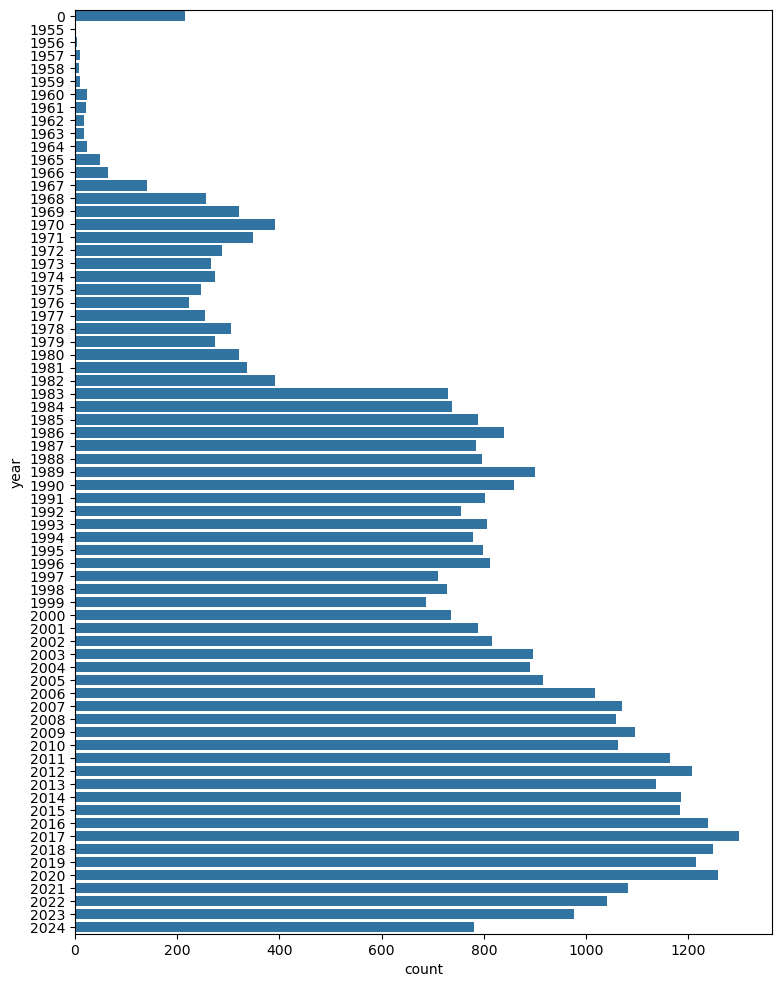

In [36]:
plt.figure(figsize=(9,12))
sns.countplot(data=df_masters_concat, y='year')

In [86]:
df_masters_concat.release_country.value_counts().head(10)

release_country
UK                 18464
US                  6078
Europe              2382
UK & Europe         1510
Germany              780
UK, Europe & US      466
Canada               419
Australia            381
UK & US              368
Japan                361
Name: count, dtype: int64

In [21]:
df_masters_concat[df_masters_concat['artist']=='Extremoduro'].sort_values('year', ascending=False)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [88]:
df_masters_concat.artist.value_counts().head(10)

artist
The Fall           71
King Crimson       66
Marillion          49
Hawkwind           45
Rick Wakeman       40
Bob Dylan          36
UK Subs            34
Dynamo Snackbar    34
The Stranglers     34
Deep Purple        33
Name: count, dtype: int64

In [89]:
df_masters_concat.genres.value_counts().head(10)

genres
['Rock']                              15384
[Rock]                                 8301
['Electronic', 'Rock']                 1719
['Rock', 'Pop']                        1596
[Electronic, Rock]                      954
[Rock, Pop]                             940
['Rock', 'Folk, World, & Country']      810
[Rock, Folk, World, & Country]          466
['Electronic', 'Rock', 'Pop']           364
['Jazz', 'Rock']                        211
Name: count, dtype: int64

In [90]:
df_masters_concat.styles.value_counts().head(10)

styles
['Indie Rock']          1292
[Indie Rock]             915
['Punk']                 845
['Alternative Rock']     788
['Prog Rock']            697
[]                       660
['Black Metal']          529
[Alternative Rock]       479
['Psychedelic Rock']     474
['Hard Rock']            434
Name: count, dtype: int64

In [91]:
df_masters_concat[df_masters_concat['release_country']=='Europe'].sort_values('artist')

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
538,207714,269937,2411574,Europe,!!!,"Strange Weather, Isn't It?",2010,40.80,9,[Album],"[Electronic, Rock, Pop]","[Indie Rock, Indie Pop]","The curiously named !!!, whose moniker can be ..."
32464,178047,1304687,11439863,Europe,1/2 Japanese,Why Not?,2018,39.45,13,['Album'],['Rock'],['Indie Rock'],Half Japanese is an art punk band formed by br...
7829,295654,74603,428476,Europe,22-20s,22-20s,2004,39.70,10,[Album],[Rock],"[Blues Rock, Indie Rock]",22-20s were an English rock band formed in Sle...
8900,166483,89120,414482,Europe,3 Doors Down,Away From The Sun,2002,46.80,12,[Album],[Rock],[Alternative Rock],"Alternative Rock (Modern Rock) from Escatawpa,..."
18994,156155,118883,737915,Europe,3 Mustaphas 3,Shopping,1987,44.72,9,"['LP', 'Album']","['Rock', 'Folk, World, & Country']",['Folk Rock'],British band [b]3 Mustaphas 3[/b] did much to ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,12268465,3149436,27982503,Europe,sign crushes motorist,Hurting,2023,30.42,10,"['Album', 'Limited Edition', 'Stereo']",['Rock'],"['Alternative Rock', 'Indie Rock', 'Noisecore']",Add as Sign Crushes Motorist
8371,99356,92889,749181,Europe,t.A.T.u.,200 KM/H In The Wrong Lane,2002,48.13,14,"[Album, Enhanced]","[Electronic, Rock, Pop]","[Europop, Breaks, Pop Rock, Ballad, Downtempo]",Russian pop girl duo formed in 2000. \r\n\r\nT...
26565,5609390,1558662,13757895,Europe,whenyoung,Reasons To Dream,2019,41.67,11,['Album'],['Rock'],['Alternative Rock'],"Whenyoung is an Irish indie rock group, origin..."
26369,7479496,1880004,14385213,Europe,wlots,Sempre Più,2019,0.00,11,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Emo', 'Hardcore', 'Post Rock', 'Punk']","Screamo from Göteborg, Sweden."


In [92]:
percentage_album_length_missing = round((df_masters_concat['album_length']==0).sum() / df_masters_concat.shape[0] * 100, 2)
print(f'% missing album_length: {percentage_album_length_missing}%')

% missing album_length: 37.19%


In [93]:
df_masters_concat['artist_profile'].isna().sum()

4592

In [94]:
percentage_artist_profile_missing = round(df_masters_concat['artist_profile'].isna().sum() / df_masters_concat.shape[0] * 100, 2)
print(f'% missing artist_profile: {percentage_artist_profile_missing}%')

% missing artist_profile: 13.39%


In [95]:
df_masters_concat[df_masters_concat['artist_profile']==''] # should be empty

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [19]:
df_masters_concat.loc[10, 'artist_profile']

'English Pop punk band from Southend-on-Sea, Essex, consisting of James Bourne, Matt Willis and Charlie Simpson. Formed in 2000, the band had four UK number-one singles, won two Brit awards and have released four studio albums, selling in excess of five million records.\r\n\r\nIn 2003, Dutch releases of this band were released under the artist name "Bust" to avoid confusion with Dutch band [a493201] who had a hit back then with "We Want More".'

In [96]:
df_masters_concat.groupby(["release_country", 'year']).agg({'master_id': 'count'}).sort_values('master_id', ascending=False).astype(int).head(15)

master_id
release_country year           
UK              2020        741
                2018        718
                2019        718
                2017        700
                2016        677
                2015        667
                2012        653
                2014        645
                2009        630
                2013        617
                2021        602
                2022        578
                2008        577
                2007        561
                2023        551